In [1]:
import sys

project_root = "/home/20230765/src"
if project_root not in sys.path:
    sys.path.append(project_root)
import json
import numpy as np
import torch
import h5py
from tqdm.notebook import tqdm
from retrieval.trajectory import (
    retrieve_nearest_neigbours,
    generate_trajectory_from_latents,
)
from retrieval.knowledge_base import create_kb
import seaborn as sns

import matplotlib.pyplot as plt
import faiss
import pickle
import time
import pandas as pd
from diffusers import DDIMScheduler
from metrics.metrics import pick_score, clip_score, fid_score, inception_score
from retrieval.pipeline_re_sd import ReSDPipeline
from PIL import Image

In [2]:
# ID-2K
trajectory_path = "../data/generated_data/trajectories.h5"

num_trajectories = 2000

np.random.seed(42)
query_set = np.random.choice(np.arange(0, num_trajectories), size=200, replace=False)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))
kb_path = "../data/reference_knowledge_base/knowledge_base.h5"
faiss_index_path = "../data/reference_knowledge_base/faiss_index.bin"
prompts_to_path = "../data/reference_knowledge_base/prompts.json"
key_margin_steps = 0
prompts = json.load(open(prompts_to_path, "r"))
coco_flg = False

In [2]:
# COCO
trajectory_path = "../data/generated_data/coco_trajectories.h5"

num_trajectories = 10000

np.random.seed(42)
query_set = np.random.choice(np.arange(0, num_trajectories), size=2000, replace=False)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))
kb_path = "../data/reference_knowledge_base/coco_knowledge_base.h5"
faiss_index_path = "../data/reference_knowledge_base/coco_faiss_index.bin"
prompts_to_path = "../data/reference_knowledge_base/coco_prompts.json"
key_margin_steps = 0
prompts = json.load(open(prompts_to_path, "r"))
coco_flg = True

### Distances distribution exploration

#### Reference

In [7]:
with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())
    reference_neighbours_list = []
    reference_distances_list = []
    reference_time = 0
    for query in tqdm(query_set):
        query = trajectory_file[traj_names[query]][key_margin_steps]
        neighbours, timing = retrieve_nearest_neigbours(
            query_array=query,
            num_neighbours=11,
            index_path=faiss_index_path,
            kb_path=kb_path,
        )

        reference_neighbours_list.append(
            [int(neighbour[2]) for neighbour in neighbours][1:]
        )
        reference_distances_list.append([neighbour[1] for neighbour in neighbours][1:])

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

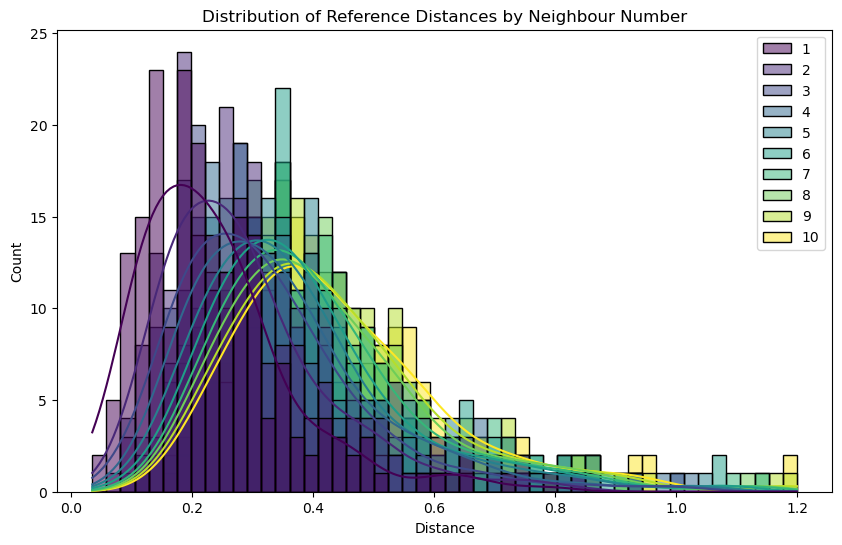

In [ ]:
flat_distances = [d for sublist in reference_distances_list for d in sublist]
flat_counts = [
    d
    for sublist in [
        np.arange(1, len(sublist) + 1) for sublist in reference_distances_list
    ]
    for d in sublist
]
max_neigh = max(flat_counts)

stats = []
for n in range(1, max_neigh + 1):
    dists = [
        flat_distances[i] for i in range(len(flat_distances)) if flat_counts[i] == n
    ]
    stats.append(
        {
            "neighbour": n,
            "mean": np.mean(dists),
            "median": np.median(dists),
            "std": np.std(dists),
        }
    )

df_stats = pd.DataFrame(stats)
df_stats.to_csv("../data/results/neighbour_distances_reference.csv", index=False)

plt.figure(figsize=(10, 6))
sns.histplot(
    x=flat_distances, hue=flat_counts, palette="viridis", bins=50, kde=True, legend=True
)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distribution of Reference Distances by Neighbour Number")
plt.show()

#### PCA64

In [4]:
config = [
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": False,
    }
]

kb_path = "../data/knowledge_base/knowledge_base.h5"
faiss_index_path = "../data/knowledge_base/faiss_index.bin"
prompts_to_path = "../data/knowledge_base/prompts.json"

use_pca = True
pca_path = "../data/knowledge_base/compression.pkl"
prompts_from_path = "../data/generated_data/coco_prompts.jsonl"
value_margin_steps = 25
key_margin_steps = 0

dim_neighbours = []
dim_distances = []
avg_times = []
for cfg in tqdm(config):
    create_kb(
        key_margin_steps=key_margin_steps,
        value_margin_steps=value_margin_steps,
        trajectory_path=trajectory_path,
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_from_path=prompts_from_path,
        prompts_to_path=prompts_to_path,
        pca_path=pca_path,
        **cfg,
    )
    # clean queries
    with h5py.File(kb_path, "a") as kb_file:
        for query in query_set:
            del kb_file[str(query)]

    # remove ids
    index = faiss.read_index(faiss_index_path)
    index.remove_ids(query_set)
    faiss.write_index(index, faiss_index_path)

    # find neigbours
    avg_times_list = []
    for i in range(1):
        neighbours_list = []
        distances_list = []
        timing = 0
        with h5py.File(trajectory_path, "r") as trajectory_file:
            traj_names = list(trajectory_file.keys())
            for query in tqdm(query_set):
                query = trajectory_file[traj_names[query]][key_margin_steps]
                if "use_pca" in cfg.keys() and cfg["use_pca"] == True:
                    pca = pickle.load(open(pca_path, "rb"))
                    start_pca = time.time()
                    query = pca.transform(query.reshape(1, -1)).squeeze()
                    end_pca = time.time()
                    elapsed_pca = end_pca - start_pca
                    timing += elapsed_pca
                neighbours, time_search = retrieve_nearest_neigbours(
                    query_array=query,
                    num_neighbours=10,
                    index_path=faiss_index_path,
                    kb_path=kb_path,
                )
                neighbours_list.append([int(neighbour[2]) for neighbour in neighbours])
                distances_list.append([neighbour[1] for neighbour in neighbours])
                timing += time_search
                # print(f"Query took {np.round(time_search, 5)} seconds")
        avg_times_list.append(timing / len(query_set))
        print(f"Avg time: {timing / len(query_set)}")
    avg_times.append(avg_times_list)
    dim_neighbours.append(neighbours_list)
    dim_distances.append(distances_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting PCA...


10000it [00:31, 313.96it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0005559931993484497


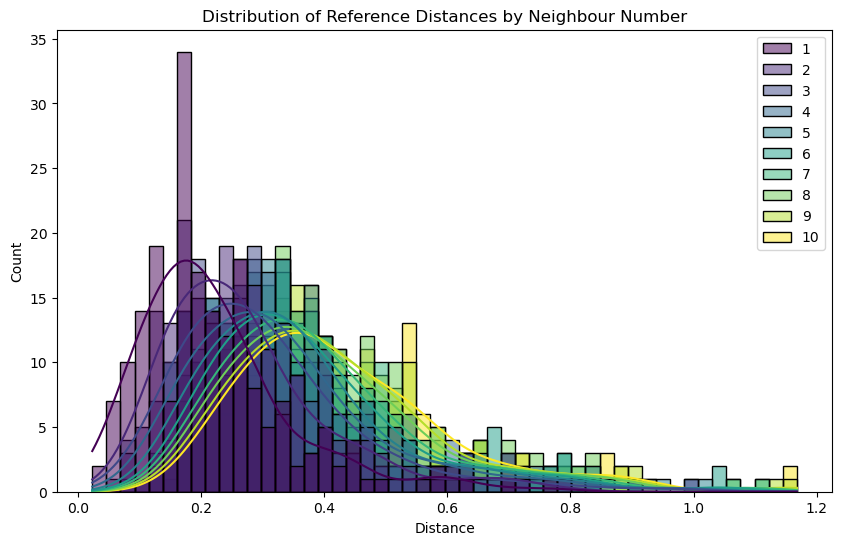

In [4]:
flat_distances = [d for sublist in distances_list for d in sublist]
flat_counts = [
    d
    for sublist in [np.arange(1, len(sublist) + 1) for sublist in distances_list]
    for d in sublist
]
max_neigh = max(flat_counts)

stats = []
for n in range(1, max_neigh + 1):
    dists = [
        flat_distances[i] for i in range(len(flat_distances)) if flat_counts[i] == n
    ]
    stats.append(
        {
            "neighbour": n,
            "mean": np.mean(dists),
            "median": np.median(dists),
            "std": np.std(dists),
            "25th_percentile": np.percentile(dists, 25),
            "75th_percentile": np.percentile(dists, 75),
        }
    )

df_stats = pd.DataFrame(stats)
df_stats.to_csv(
    "../data/results/adaptive_skipping/coco_neighbour_distances_pca=64.csv", index=False
)

plt.figure(figsize=(10, 6))
sns.histplot(
    x=flat_distances, hue=flat_counts, palette="viridis", bins=50, kde=True, legend=True
)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distribution of Reference Distances by Neighbour Number")
plt.show()

### Adaptive skipping

In [5]:
adaptive_skipping_config = [
    [15, 20, 24, 27],
    [20, 23, 25, 28],
    [23, 24, 26, 29],
]
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda:1")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
num_queries = len(query_set)

clips_real = []
clips_generated = []
clips_generated_group = []
clips_real_group = []
picks = []
picks_group = []
inceptions_real = []
inceptions_generated = []
fids = []
avg_steps = []
steps_dist = []
if coco_flg == True:
    coco_picks = []
    neighbour_coco_picks = []
    coco_clips = []
    fids_coco = []
    fids_neighbour = []
    inceptions_coco = []

    # download coco images and map them
    import requests
    from concurrent.futures import ThreadPoolExecutor
    import io
    from pycocotools.coco import COCO

    coco = COCO("../data/coco_annotations/instances_train2017.json")
    with open("../data/generated_data/prompts/coco_prompt_to_image_id.json", "r") as f:
        coco_prompt_to_image_id = json.load(f)

    def download_image(info):
        try:
            response = requests.get(info["coco_url"], timeout=10)
            response.raise_for_status()
            return Image.open(io.BytesIO(response.content)).convert("RGB")
        except Exception as e:
            print(f"Failed to download {info['id']}: {e}")
            return None

    image_infos = coco.loadImgs(ids=list(coco_prompt_to_image_id.values()))

    with ThreadPoolExecutor(max_workers=512) as executor:
        images = list(
            tqdm(
                executor.map(download_image, image_infos),
                total=len(image_infos),
                desc="Downloading images",
            )
        )
        coco_images_dict = {
            info["id"]: img for info, img in zip(image_infos, images) if img is not None
        }

for config in tqdm(adaptive_skipping_config):
    resulting_images = []
    pick = []
    steps = []
    if coco_flg == True:
        pick_coco = []
        pick_coco_neighbour = []
    with h5py.File(trajectory_path, "r") as trajectory_file:
        traj_names = list(trajectory_file.keys())
        for query_index in tqdm(range(num_queries)):
            neighbour = dim_neighbours[0][query_index][0]
            distance = dim_distances[0][query_index][0]
            # define adaptive value_margin_steps
            if distance < 0.1:
                value_margin_steps = config[0]
            elif distance < 0.2:
                value_margin_steps = config[1]
            elif distance < 0.3:
                value_margin_steps = config[2]
            else:
                value_margin_steps = config[3]
            steps.append(value_margin_steps)
            neighbour_latent = trajectory_file[traj_names[neighbour]][
                -(value_margin_steps + 1)
            ]
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]

            prompt = prompts[str(query_set[query_index])]

            img_real = pipe.decode_latent_to_image(
                latent=last_real_latent,
            )

            img_real_from_neighbour = generate_trajectory_from_latents(
                prompt=prompt,
                latent=neighbour_latent,
                device="cuda:1",
                num_inference_steps=30,
                value_margin_steps=value_margin_steps,
                scheduler=DDIMScheduler,
                pipeline=pipe,
            )[0]
            if coco_flg == True:
                coco_img = coco_images_dict[coco_prompt_to_image_id[prompt]].resize(
                    (512, 512)
                )
                resulting_images.append([img_real_from_neighbour, img_real, coco_img])
            else:
                resulting_images.append([img_real_from_neighbour, img_real])

            # metrics
            pick.append(
                pick_score(
                    prompt=prompt,
                    images=[img_real_from_neighbour, img_real],
                )[0]
            )
            if coco_flg == True:
                pick_coco_neighbour.append(
                    pick_score(
                        prompt=prompt,
                        images=[img_real_from_neighbour, coco_img],
                    )[0]
                )
                pick_coco.append(
                    pick_score(
                        prompt=prompt,
                        images=[img_real, coco_img],
                    )[0]
                )
        real_images = [images[1] for images in resulting_images]
        generated_images = [images[0] for images in resulting_images]
        avg_steps.append(np.mean(steps))

        clip_real = clip_score(
            images=real_images,
            prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
        )
        clip_generated = clip_score(
            images=generated_images,
            prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
        )

        fid = fid_score(
            real_images=real_images[:num_queries],
            generated_images=generated_images[:num_queries],
        )

        inception_real = inception_score(images=real_images)
        inception_generated = inception_score(images=generated_images)

        # groupwise pick and clip scores
        pick_score_group = []
        clip_score_group_real = []
        clip_score_group_generated = []
        for step in config:
            pick_score_group.append(
                np.mean([pick[i] for i in range(num_queries) if steps[i] == step])
            )
            clip_score_group_real.append(
                clip_score(
                    images=[
                        real_images[i] for i in range(num_queries) if steps[i] == step
                    ],
                    prompts=[
                        prompts[str(query_set[i])]
                        for i in range(num_queries)
                        if steps[i] == step
                    ],
                )
            )
            clip_score_group_generated.append(
                clip_score(
                    images=[
                        generated_images[i]
                        for i in range(num_queries)
                        if steps[i] == step
                    ],
                    prompts=[
                        prompts[str(query_set[i])]
                        for i in range(num_queries)
                        if steps[i] == step
                    ],
                )
            )

        print("FID gen vs retrieval: ", fid)
        print("Inception score real: ", inception_real)
        print("Inception score generated: ", inception_generated)
        print("CLIP score real: ", clip_real)
        print("CLIP score generated: ", clip_generated)
        print("Pick score: ", np.mean(pick))
        print("Avg steps: ", np.mean(steps))
        print("Groups: ", config)
        print("Groupwise pick score: ", pick_score_group)
        print("Groupwise clip score real: ", clip_score_group_real)
        print("Groupwise clip score generated: ", clip_score_group_generated)

        fids.append(fid)
        inceptions_real.append(inception_real)
        inceptions_generated.append(inception_generated)
        clips_real.append(clip_real)
        clips_generated.append(clip_generated)
        picks.append(np.mean(pick))

        picks_group.append(pick_score_group)
        clips_real_group.append(clip_score_group_real)
        clips_generated_group.append(clip_score_group_generated)

        clip_score_group = []

        if coco_flg == True:
            coco_images = [images[2] for images in resulting_images]
            clip_coco = clip_score(
                images=coco_images,
                prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
            )
            fid_coco = fid_score(
                real_images=coco_images,
                generated_images=real_images[:num_queries],
            )
            fid_neighbour = fid_score(
                real_images=coco_images,
                generated_images=generated_images[:num_queries],
            )
            inception_coco = inception_score(images=coco_images)
            print("FID gen vs coco: ", fid_coco)
            print("FID retrieval vs coco: ", fid_neighbour)
            print("Inception score coco: ", inception_coco)
            print("CLIP score coco: ", clip_coco)
            print("Pick score gen vs coco: ", np.mean(pick_coco))
            print("Pick score retrieval vs coco: ", np.mean(pick_coco_neighbour))
            fids_coco.append(fid_coco)
            fids_neighbour.append(fid_neighbour)
            inceptions_coco.append(inception_coco)
            coco_clips.append(clip_coco)
            coco_picks.append(np.mean(pick_coco))
            neighbour_coco_picks.append(np.mean(pick_coco_neighbour))

loading annotations into memory...
Done (t=4.83s)
creating index...
index created!


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/anaconda/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/anaconda/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
/home/20230765/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*arg

FID gen vs retrieval:  23.76111602783203
Inception score real:  (22.78056526184082, 2.350802183151245)
Inception score generated:  (21.25092124938965, 1.629257321357727)
CLIP score real:  31.4385
CLIP score generated:  30.7687
Pick score:  0.43692641709838065
Avg steps:  22.0845
Groups:  [15, 20, 24, 27]
Groupwise pick score:  [0.43873385931777803, 0.40671109157292884, 0.4426051213416491, 0.46727301960899714]
Groupwise clip score real:  [30.619, 30.9743, 31.7057, 32.1993]
Groupwise clip score generated:  [29.947, 29.9804, 30.9594, 31.96]
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.1258659362793
Inception score coco:  (19.043001174926758, 0.9079776406288147)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5214247269737534


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  22.262269973754883
Inception score real:  (22.579713821411133, 1.3482167720794678)
Inception score generated:  (21.505666732788086, 2.2990944385528564)
CLIP score real:  31.4385
CLIP score generated:  31.0603
Pick score:  0.4569660088531673
Avg steps:  24.3885
Groups:  [20, 23, 25, 28]
Groupwise pick score:  [0.45448300019613924, 0.4427001441363245, 0.4573162055668536, 0.47498268308200114]
Groupwise clip score real:  [30.619, 30.9743, 31.7057, 32.1993]
Groupwise clip score generated:  [30.3048, 30.4753, 31.1146, 32.0379]
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.01374435424805
Inception score coco:  (18.84537696838379, 1.379470944404602)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5396467686882243


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  20.474403381347656
Inception score real:  (22.687408447265625, 1.048356294631958)
Inception score generated:  (22.019046783447266, 1.8692659139633179)
CLIP score real:  31.4385
CLIP score generated:  31.2008
Pick score:  0.4714622254893184
Avg steps:  25.7045
Groups:  [23, 24, 26, 29]
Groupwise pick score:  [0.47001612205294113, 0.4583586774367307, 0.46686158473237177, 0.4914090299233137]
Groupwise clip score real:  [30.619, 30.9743, 31.7057, 32.1993]
Groupwise clip score generated:  [30.5137, 30.6415, 31.2881, 32.1072]
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.60981369018555
Inception score coco:  (18.940969467163086, 1.5305613279342651)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5538785379081964


In [23]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame(
    {
        "Skipping configuration": ["Aggressive", "Moderate", "Conservative"],
        "CLIP Score Real": clips_real,
        "CLIP Score Generated": clips_generated,
        "Groupwise CLIP Score Real": clips_real_group,
        "Groupwise CLIP Score Generated": clips_generated_group,
        "Pick score retrieval vs gen": picks,
        "Groupwise Pick score retrieval vs gen": picks_group,
        "Inception Score Real": inceptions_real,
        "Inception Score Generated": inceptions_generated,
        "FID retrieval vs gen": fids,
        "Average Steps": avg_steps,
    }
)

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index("Skipping configuration")

# # Save to CSV
metrics_df.to_csv("../data/results/adaptive_skipping/metrics-skipping.csv")

# Display the table
metrics_df

,CLIP Score Real,CLIP Score Generated,Groupwise CLIP Score Real,Groupwise CLIP Score Generated,Pick score retrieval vs gen,Groupwise Pick score retrieval vs gen,Inception Score Real,Inception Score Generated,FID retrieval vs gen,Average Steps
Skipping configuration,,,,,,,,,,
Aggressive,30.9534,30.4029,"[31.8391, 30.5752, 30.8817, 28.8883]","[31.0542, 30.0553, 30.0148, 28.7]",0.479772,"[0.4764793701469898, 0.4869698262995198, 0.466...","(5.868754863739014, 1.0341933965682983)","(5.708542346954346, 0.5127373933792114)",71.828606,21.795
Moderate,30.9534,30.6417,"[31.8391, 30.5752, 30.8817, 28.8883]","[31.1856, 30.4342, 30.137, 28.5739]",0.483814,"[0.4646183488269647, 0.498903951829388, 0.4733...","(5.491359233856201, 0.4743226170539856)","(6.035892963409424, 1.2192829847335815)",70.165390,24.115
Conservative,30.9534,30.6266,"[31.8391, 30.5752, 30.8817, 28.8883]","[31.2604, 30.2604, 30.1358, 28.68]",0.494809,"[0.4768149716158708, 0.504639571976094, 0.4859...","(5.723114967346191, 1.134819507598877)","(6.030857086181641, 1.0215353965759277)",65.716385,25.355


In [7]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame(
    {
        "Skipping configuration": ["Aggressive", "Moderate", "Conservative"],
        "CLIP Score Real": clips_real,
        "CLIP Score Generated": clips_generated,
        "CLIP Score Coco": coco_clips,
        "Groupwise CLIP Score Real": clips_real_group,
        "Groupwise CLIP Score Generated": clips_generated_group,
        "Pick score retrieval vs gen": picks,
        "Groupwise Pick score retrieval vs gen": picks_group,
        "Pick score gen vs coco": coco_picks,
        "Pick score retrieval vs coco": neighbour_coco_picks,
        "Inception Score Real": inceptions_real,
        "Inception Score Generated": inceptions_generated,
        "Inception Score Coco": inceptions_coco,
        "FID retrieval vs gen": fids,
        "FID gen vs coco": fids_coco,
        "FID retrieval vs coco": fids_neighbour,
        "Average Steps": avg_steps,
    }
)

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index("Skipping configuration")

# # Save to CSV
metrics_df.to_csv("../data/results/adaptive_skipping/coco-metrics-skipping.csv")

# Display the table
metrics_df

,CLIP Score Real,CLIP Score Generated,CLIP Score Coco,Groupwise CLIP Score Real,Groupwise CLIP Score Generated,Pick score retrieval vs gen,Groupwise Pick score retrieval vs gen,Pick score gen vs coco,Pick score retrieval vs coco,Inception Score Real,Inception Score Generated,Inception Score Coco,FID retrieval vs gen,FID gen vs coco,FID retrieval vs coco,Average Steps
Skipping configuration,,,,,,,,,,,,,,,,
Aggressive,31.4385,30.7687,30.3002,"[30.619, 30.9743, 31.7057, 32.1993]","[29.947, 29.9804, 30.9594, 31.96]",0.436926,"[0.43873385931777803, 0.40671109157292884, 0.4...",0.579328,0.521425,"(22.78056526184082, 2.350802183151245)","(21.25092124938965, 1.629257321357727)","(19.043001174926758, 0.9079776406288147)",23.761116,51.893341,52.125866,22.0845
Moderate,31.4385,31.0603,30.3002,"[30.619, 30.9743, 31.7057, 32.1993]","[30.3048, 30.4753, 31.1146, 32.0379]",0.456966,"[0.45448300019613924, 0.4427001441363245, 0.45...",0.579328,0.539647,"(22.579713821411133, 1.3482167720794678)","(21.505666732788086, 2.2990944385528564)","(18.84537696838379, 1.379470944404602)",22.262270,51.893341,52.013744,24.3885
Conservative,31.4385,31.2008,30.3002,"[30.619, 30.9743, 31.7057, 32.1993]","[30.5137, 30.6415, 31.2881, 32.1072]",0.471462,"[0.47001612205294113, 0.4583586774367307, 0.46...",0.579328,0.553879,"(22.687408447265625, 1.048356294631958)","(22.019046783447266, 1.8692659139633179)","(18.940969467163086, 1.5305613279342651)",20.474403,51.893341,52.609814,25.7045
